In [2]:
!pip install vectorbt yfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.6/527.6 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 43.7 MB/s eta 0:00:00


# Momentum Backtesting

## Baseline Backtesting

In [ ]:
import vectorbt as vbt
import numpy as np
import pandas as pd
from datetime import datetime

class MomentumStrategyVectorBT:
    def __init__(self,
                 symbols=None,
                 momentum_threshold= 10.0,
                 stop_loss_pct=0.10,
                 start_date='2022-01-01',
                 end_date=None):
        if symbols is None:
            symbols = ["GOOGL", "AAPL", "AMZN", "META", "MSFT", "NVDA"]
        self.symbols = symbols
        self.momentum_threshold = momentum_threshold
        self.stop_loss_pct = stop_loss_pct
        self.start_date = start_date
        self.end_date = end_date if end_date else datetime.now().strftime('%Y-%m-%d')

        # Download daily Close prices (using 'Close' since auto_adjust=True by default)
        self.price_data = vbt.YFData.download(
            symbols=self.symbols,
            start=self.start_date,
            end=self.end_date
        ).get('Close')

        self.pf = None

    def calculate_momentum(self, df=None):
        """
        Compute the rolling momentum factor using a 252-day window.
        """
        if df is None:
            df = self.price_data

        def momentum_factor(window):
            returns = window.pct_change().iloc[-126:]
            std_returns = np.std(returns)
            if std_returns == 0 or np.isnan(std_returns):
                return np.nan
            return (((window.iloc[-21] - window.iloc[-252]) / window.iloc[-252]) -
                    ((window.iloc[-1] - window.iloc[-21]) / window.iloc[-21])) / std_returns

        momentum_df = df.rolling(window=252).apply(momentum_factor, raw=False)
        return momentum_df

    def run_backtest(self):
        """
        Uses VectorBT to backtest the strategy.
        Generates long/short signals from the momentum factor and adds a stop loss exit
        based on a daily adverse move greater than stop_loss_pct.
        """
        momentum = self.calculate_momentum()
        print(momentum)
        # Generate signals based solely on momentum
        long_entries = momentum > self.momentum_threshold
        long_exits = momentum <= self.momentum_threshold
        short_entries = momentum < -self.momentum_threshold
        short_exits = momentum >= -self.momentum_threshold

        # Incorporate a simple stop loss:
        # For longs: if today's return is less than -stop_loss_pct, trigger an exit.
        # For shorts: if today's return is above stop_loss_pct, trigger an exit.
        daily_returns = self.price_data.pct_change()
        stop_loss_long = daily_returns < -self.stop_loss_pct
        stop_loss_short = daily_returns > self.stop_loss_pct

        # Combine momentum-based exits with stop loss exits
        final_long_exits = long_exits | stop_loss_long
        final_short_exits = short_exits | stop_loss_short

        # Build portfolio using VectorBT's from_signals
        self.pf = vbt.Portfolio.from_signals(
            close=self.price_data,
            entries=long_entries,
            exits=final_long_exits,
            short_entries=short_entries,
            short_exits=final_short_exits,
            fees=0.001,
            slippage=0.001,
            freq='1D'
        )

        print("Backtest Summary:")
        print(self.pf.stats())

    def run_live_strategy(self):
        """
        Simulate a live trading strategy using your trading logic.
        This method mimics:
          - Checking current positions (here, simulated via a dictionary)
          - Calculating momentum from the most recent historical data
          - Determining cash allocation per symbol
          - Executing entry/exit orders based on momentum and stop loss.
        """
        print("Running live strategy simulation...")
        # For simulation, assume account info and positions are as follows:
        account_cash = 100000  # available cash
        positions = {}  # current positions; e.g., {"AAPL": {"qty": 100, "entry_price": 150.0}, ...}
        allocation_per_stock = (account_cash * 0.9) / len(self.symbols)

        # Use the most recent data point for each symbol
        latest_prices = self.price_data.iloc[-1]
        # Calculate momentum using the latest available window
        momentum_series = self.calculate_momentum()
        latest_momentum = momentum_series.iloc[-1]

        for symbol in self.symbols:
            print(f"Analyzing {symbol}...")
            current_price = latest_prices[symbol]
            symbol_momentum = latest_momentum[symbol]
            qty_for_new_position = int(allocation_per_stock // current_price)

            if qty_for_new_position <= 0:
                print(f"Not enough cash to trade {symbol} at ${current_price:.2f}")
                continue

            existing_position = positions.get(symbol)

            # ----- MOMENTUM-BASED LIQUIDATION -----
            if existing_position:
                pos_qty = existing_position['qty']
                # For LONG positions: if momentum falls below threshold, liquidate
                if pos_qty > 0 and (symbol_momentum <= self.momentum_threshold):
                    print(f"Liquidating LONG {symbol}: momentum {symbol_momentum:.2%} <= {self.momentum_threshold:.2%}")
                    positions.pop(symbol)
                # For SHORT positions: if momentum rises above -threshold, cover
                elif pos_qty < 0 and (symbol_momentum >= -self.momentum_threshold):
                    print(f"Covering SHORT {symbol}: momentum {symbol_momentum:.2%} >= {-self.momentum_threshold:.2%}")
                    positions.pop(symbol)

            # ----- ENTRY LOGIC -----
            if symbol_momentum > self.momentum_threshold:
                if symbol in positions:
                    print(f"Already in position for {symbol}; no additional BUY.")
                else:
                    print(f"BUY signal for {symbol}: momentum {symbol_momentum:.2%} > {self.momentum_threshold:.2%}.")
                    print(f"Placing market BUY for {qty_for_new_position} shares at ${current_price:.2f}.")
                    positions[symbol] = {'qty': qty_for_new_position, 'entry_price': current_price}
            elif symbol_momentum < -self.momentum_threshold:
                if symbol in positions:
                    print(f"Already in position for {symbol}; no additional SHORT.")
                else:
                    print(f"SHORT signal for {symbol}: momentum {symbol_momentum:.2%} < {-self.momentum_threshold:.2%}.")
                    print(f"Placing market SHORT for {qty_for_new_position} shares at ${current_price:.2f}.")
                    positions[symbol] = {'qty': -qty_for_new_position, 'entry_price': current_price}
            else:
                print(f"No trading action for {symbol}: momentum {symbol_momentum:.2%} within thresholds.")

            # ----- STOP LOSS LOGIC -----
            # If in a long position and current price drops below entry_price*(1 - stop_loss_pct), exit.
            if symbol in positions:
                pos = positions[symbol]
                entry_price = pos['entry_price']
                if pos['qty'] > 0 and (current_price < entry_price * (1 - self.stop_loss_pct)):
                    print(f"STOP LOSS triggered for LONG {symbol}: current price ${current_price:.2f} below ${entry_price*(1-self.stop_loss_pct):.2f}. Liquidating position.")
                    positions.pop(symbol)
                # For a short position, if current price rises above entry_price*(1 + stop_loss_pct), cover.
                elif pos['qty'] < 0 and (current_price > entry_price * (1 + self.stop_loss_pct)):
                    print(f"STOP LOSS triggered for SHORT {symbol}: current price ${current_price:.2f} above ${entry_price*(1+self.stop_loss_pct):.2f}. Covering position.")
                    positions.pop(symbol)

        print("Live strategy simulation completed.")
        print("Final positions:", positions)

    def plot_results(self, show_all_symbols=False):
        if self.pf is None:
            print("No portfolio to plot. Please run_backtest() first.")
            return

        if show_all_symbols:
            for symbol in self.price_data.columns:
                fig = self.pf.plot(column=symbol)
                fig.update_layout(title=f"{symbol} Backtest Orders")
                fig.show()
        else:
            first_sym = self.price_data.columns[0]
            fig = self.pf.plot(column=first_sym)
            fig.update_layout(title=f"{first_sym} Backtest Orders")
            fig.show()


if __name__ == "__main__":
    bot = MomentumStrategyVectorBT(
        symbols=["GOOGL", "AAPL", "AMZN", "META", "MSFT", "NVDA"],
        momentum_threshold = 15,
        stop_loss_pct = 0.05,
        start_date="2020-01-01"
    )

    # Run the VectorBT backtest
    bot.run_backtest()

    # Uncomment to plot the backtest results:
    #bot.plot_results(show_all_symbols=True)

symbol                         GOOGL       AAPL       AMZN       META  \
Date                                                                    
2020-01-02 05:00:00+00:00        NaN        NaN        NaN        NaN   
2020-01-03 05:00:00+00:00        NaN        NaN        NaN        NaN   
2020-01-06 05:00:00+00:00        NaN        NaN        NaN        NaN   
2020-01-07 05:00:00+00:00        NaN        NaN        NaN        NaN   
2020-01-08 05:00:00+00:00        NaN        NaN        NaN        NaN   
...                              ...        ...        ...        ...   
2025-03-24 04:00:00+00:00  15.107012  37.998182  13.458175  21.780722   
2025-03-25 04:00:00+00:00  10.373152  36.476591  12.578969  18.869779   
2025-03-26 04:00:00+00:00  10.484528  33.508679  14.280428  23.946600   
2025-03-27 04:00:00+00:00   8.342233  31.391108  11.566537  22.763360   
2025-03-28 04:00:00+00:00  11.570718  33.654602  14.964949  26.479276   

symbol                         MSFT       NVDA  
D

<ipython-input-7-10d8da1ca8a4>:94: UserWarning: Object has multiple columns. Aggregating using <function mean at 0x79e2d2d10c20>. Pass column to select a single column/group.
  print(self.pf.stats())


# Optimized Backtesting with Random Forest using Grid Search

## Optimizing Probability Threshold, Momentum Threshold, and Stoploss Multiplier


In [ ]:
!pip install vectorbt yfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.6/527.6 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 44.0 MB/s eta 0:00:00


In [ ]:
import vectorbt as vbt
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import itertools
import pickle

class MomentumStrategyVectorBT:
    def __init__(self,
                 symbols=None,
                 momentum_threshold=10.0,      # default threshold for normalized momentum
                 stop_loss_multiplier=2.0,       # adaptive stop loss factor
                 long_prob_threshold=0.6,        # probability threshold for long entries
                 short_prob_threshold=0.4,       # probability threshold for short entries
                 start_date='2020-01-01',        # extended backtest period
                 end_date=None,
                 rf_params=None):                # random forest parameters
        if symbols is None:
            symbols = ["GOOGL", "AAPL", "AMZN", "META", "MSFT", "NVDA"]
        self.symbols = symbols
        self.momentum_threshold = momentum_threshold
        self.stop_loss_multiplier = stop_loss_multiplier
        self.long_prob_threshold = long_prob_threshold
        self.short_prob_threshold = short_prob_threshold
        self.start_date = start_date
        self.end_date = end_date if end_date else datetime.now().strftime('%Y-%m-%d')

        if rf_params is None:
            rf_params = {'n_estimators': 100, 'max_depth': None}
        self.rf_params = rf_params

        # Download daily Close prices (auto_adjust=True by default)
        self.price_data = vbt.YFData.download(
            symbols=self.symbols,
            start=self.start_date,
            end=self.end_date
        ).get('Close')

        self.pf = None

    def calculate_momentum(self, df=None):
        """
        Compute the rolling momentum factor using a 252-day window.
        The factor is defined as:
            factor = [((close[-21] - close[-252]) / close[-252])
                      - ((close[-1] - close[-21]) / close[-21])]
                     / std(returns over last 126 days)
        """
        if df is None:
            df = self.price_data

        def momentum_factor(window):
            returns = window.pct_change().iloc[-126:]
            std_returns = np.std(returns)
            if std_returns == 0 or np.isnan(std_returns):
                return np.nan
            return (((window.iloc[-21] - window.iloc[-252]) / window.iloc[-252]) -
                    ((window.iloc[-1] - window.iloc[-21]) / window.iloc[-21])) / std_returns

        momentum_df = df.rolling(window=252).apply(momentum_factor, raw=False)
        return momentum_df

    def run_backtest(self):
        # Calculate normalized momentum factor
        momentum = self.calculate_momentum()

        # Corrective AI: For each symbol, build features & train a RF model to predict 5-day forward return.
        prob_df = pd.DataFrame(index=momentum.index, columns=momentum.columns)
        for symbol in self.symbols:
            price = self.price_data[symbol]
            m = momentum[symbol]

            # Calculate a 10-day rolling volatility
            vol = price.pct_change().rolling(10).std()
            # Compute RSI using VectorBT's built-in indicator
            rsi = vbt.RSI.run(price).rsi

            features = pd.DataFrame({
                'momentum': m,
                'volatility': vol,
                'rsi': rsi
            }).dropna()

            # Skip if not enough data to train
            if len(features) < 50:
                continue

            # Label: if 5-day forward return is positive → 1, else 0.
            future_return = price.shift(-5) / price - 1
            labels = future_return.loc[features.index]
            labels = (labels > 0).astype(int)

            X = features
            y = labels

            # Split in a time-series–aware manner
            X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)
            # Use the RF parameters from self.rf_params
            model = RandomForestClassifier(**self.rf_params, random_state=42)
            model.fit(X_train, y_train)
            prob = pd.Series(model.predict_proba(X)[:, 1], index=X.index)
            prob = prob.reindex(momentum.index)
            prob_df[symbol] = prob

        # Filter signals using Corrective AI with probability thresholds:
        base_long_entries = momentum > self.momentum_threshold
        base_short_entries = momentum < -self.momentum_threshold
        corrected_long_entries = base_long_entries & (prob_df > self.long_prob_threshold)
        corrected_short_entries = base_short_entries & (prob_df < self.short_prob_threshold)

        # Adaptive Stop Loss: using a 20-day rolling volatility on daily returns.
        daily_returns = self.price_data.pct_change()
        vol_daily = self.price_data.pct_change().rolling(20).std()
        adaptive_stop_long = daily_returns < (-self.stop_loss_multiplier * vol_daily)
        adaptive_stop_short = daily_returns > (self.stop_loss_multiplier * vol_daily)

        # Define exits: either momentum reversion or adaptive stop loss.
        long_exits = (momentum <= self.momentum_threshold) | adaptive_stop_long
        short_exits = (momentum >= -self.momentum_threshold) | adaptive_stop_short

        # Build the portfolio
        self.pf = vbt.Portfolio.from_signals(
            close=self.price_data,
            entries=corrected_long_entries,
            exits=long_exits,
            short_entries=corrected_short_entries,
            short_exits=short_exits,
            fees=0.001,
            slippage=0.001,
            freq='1D'
        )

    def optimize_strategy(self, momentum_threshold_range, stop_loss_multiplier_range, rf_param_grid,
                          long_prob_threshold_range, short_prob_threshold_range):
        """
        Optimize the strategy over a grid of parameters and return a DataFrame with the results.
        """
        results = []
        param_combinations = list(itertools.product(momentum_threshold_range,
                                                    stop_loss_multiplier_range,
                                                    rf_param_grid,
                                                    long_prob_threshold_range,
                                                    short_prob_threshold_range))
        # Use a single progress bar over all combinations
        with tqdm(total=len(param_combinations), desc="Optimizing parameters") as pbar:
            for comb in param_combinations:
                thr, sl, rf_params, long_prob, short_prob = comb
                strategy = MomentumStrategyVectorBT(
                    symbols=self.symbols,
                    momentum_threshold=thr,
                    stop_loss_multiplier=sl,
                    start_date=self.start_date,
                    end_date=self.end_date,
                    rf_params=rf_params
                )
                # Set probability thresholds on the new instance:
                strategy.long_prob_threshold = long_prob
                strategy.short_prob_threshold = short_prob

                strategy.run_backtest()
                stats = strategy.pf.stats(silence_warnings=True)
                results.append({
                    'momentum_threshold': thr,
                    'stop_loss_multiplier': sl,
                    'n_estimators': rf_params['n_estimators'],
                    'max_depth': rf_params.get('max_depth'),
                    'long_prob_threshold': long_prob,
                    'short_prob_threshold': short_prob,
                    'Total Return [%]': stats.get('Total Return [%]', np.nan),
                    'Sharpe Ratio': stats.get('Sharpe Ratio', np.nan),
                    'Calmar Ratio': stats.get('Calmar Ratio', np.nan),
                    'Profit Factor': stats.get('Profit Factor', np.nan)
                })
                pbar.set_postfix({'Sharpe': stats.get('Sharpe Ratio', np.nan)})
                pbar.update(1)
        return pd.DataFrame(results)

    def plot_results(self, show_all_symbols=False):
        if self.pf is None:
            print("No portfolio to plot. Please run_backtest() first.")
            return

        if show_all_symbols:
            for symbol in self.price_data.columns:
                fig = self.pf.plot(column=symbol)
                fig.update_layout(title=f"{symbol} Backtest Orders")
                fig.show()
        else:
            first_sym = self.price_data.columns[0]
            fig = self.pf.plot(column=first_sym)
            fig.update_layout(title=f"{first_sym} Backtest Orders")
            fig.show()


if __name__ == "__main__":
    # Define ranges
    momentum_threshold_range = [0.1,1.0, 2.0, 2.5, 3.0, 4.0, 4.5, 5.0, 7.5, 8.0, 9.0, 10.0, 12.0, 15.0, 20.0]
    stop_loss_multiplier_range = [1.1, 1.2, 1.25, 1.3, 1.5]
    long_prob_threshold_range = [0.45, 0.50, 0.55, 0.6, 0.65, 0.70]
    short_prob_threshold_range = [0.25, 0.30, 0.35, 0.4, 0.44]
    rf_param_grid = [
        {'n_estimators': 150, 'max_depth': None},
        {'n_estimators': 150, 'max_depth': 5},
        {'n_estimators': 150, 'max_depth': 10},
        {'n_estimators': 150, 'max_depth': 15},
        {'n_estimators': 150, 'max_depth': 20}
    ]

    # Create a base strategy instance (parameters here will be overridden by optimize_strategy)
    base_strategy = MomentumStrategyVectorBT(
        symbols=["GOOGL", "AAPL", "AMZN", "META", "MSFT", "NVDA"],
        start_date="2020-01-01"
    )

    # Run the optimization over all parameter grids
    optimization_results = base_strategy.optimize_strategy(
        momentum_threshold_range,
        stop_loss_multiplier_range,
        rf_param_grid,
        long_prob_threshold_range,
        short_prob_threshold_range
    )
    print("Optimization Results:")
    print(optimization_results)

    best = optimization_results.sort_values(by='Sharpe Ratio', ascending=False).head(1)
    print("\nBest Parameter Combination:")
    print(best)

    # Save the optimization results to a pickle file
    with open("optimization_results.pkl", "wb") as f:
        pickle.dump(optimization_results, f)


Optimizing parameters: 100%|██████████| 11250/11250 [12:55:35<00:00,  4.14s/it, Sharpe=1.33]

Optimization Results:
       momentum_threshold  stop_loss_multiplier  n_estimators  max_depth  \
0                     0.1                   1.1           150        NaN   
1                     0.1                   1.1           150        NaN   
2                     0.1                   1.1           150        NaN   
3                     0.1                   1.1           150        NaN   
4                     0.1                   1.1           150        NaN   
...                   ...                   ...           ...        ...   
11245                20.0                   1.5           150       20.0   
11246                20.0                   1.5           150       20.0   
11247                20.0                   1.5           150       20.0   
11248                20.0                   1.5           150       20.0   
11249                20.0                   1.5           150       20.0   

       long_prob_threshold  short_prob_threshold  Total Return [%

# Re-run Backtest with Optimal Results

GOOGL - Train Accuracy: 1.00, Test Accuracy: 0.50, Precision: 0.48, Recall: 0.57, F1: 0.52, ROC AUC: 0.54
AAPL - Train Accuracy: 1.00, Test Accuracy: 0.47, Precision: 0.51, Recall: 0.58, F1: 0.54, ROC AUC: 0.46
AMZN - Train Accuracy: 1.00, Test Accuracy: 0.46, Precision: 0.46, Recall: 0.62, F1: 0.53, ROC AUC: 0.44
META - Train Accuracy: 0.99, Test Accuracy: 0.46, Precision: 0.50, Recall: 0.51, F1: 0.50, ROC AUC: 0.45
MSFT - Train Accuracy: 1.00, Test Accuracy: 0.47, Precision: 0.47, Recall: 0.71, F1: 0.57, ROC AUC: 0.48
NVDA - Train Accuracy: 1.00, Test Accuracy: 0.53, Precision: 0.51, Recall: 0.64, F1: 0.57, ROC AUC: 0.51
Start                          2020-01-02 05:00:00+00:00
End                            2025-04-04 04:00:00+00:00
Period                                1322 days 00:00:00
Start Value                                        100.0
End Value                                     733.959702
Total Return [%]                              633.959702
Benchmark Return [%]       

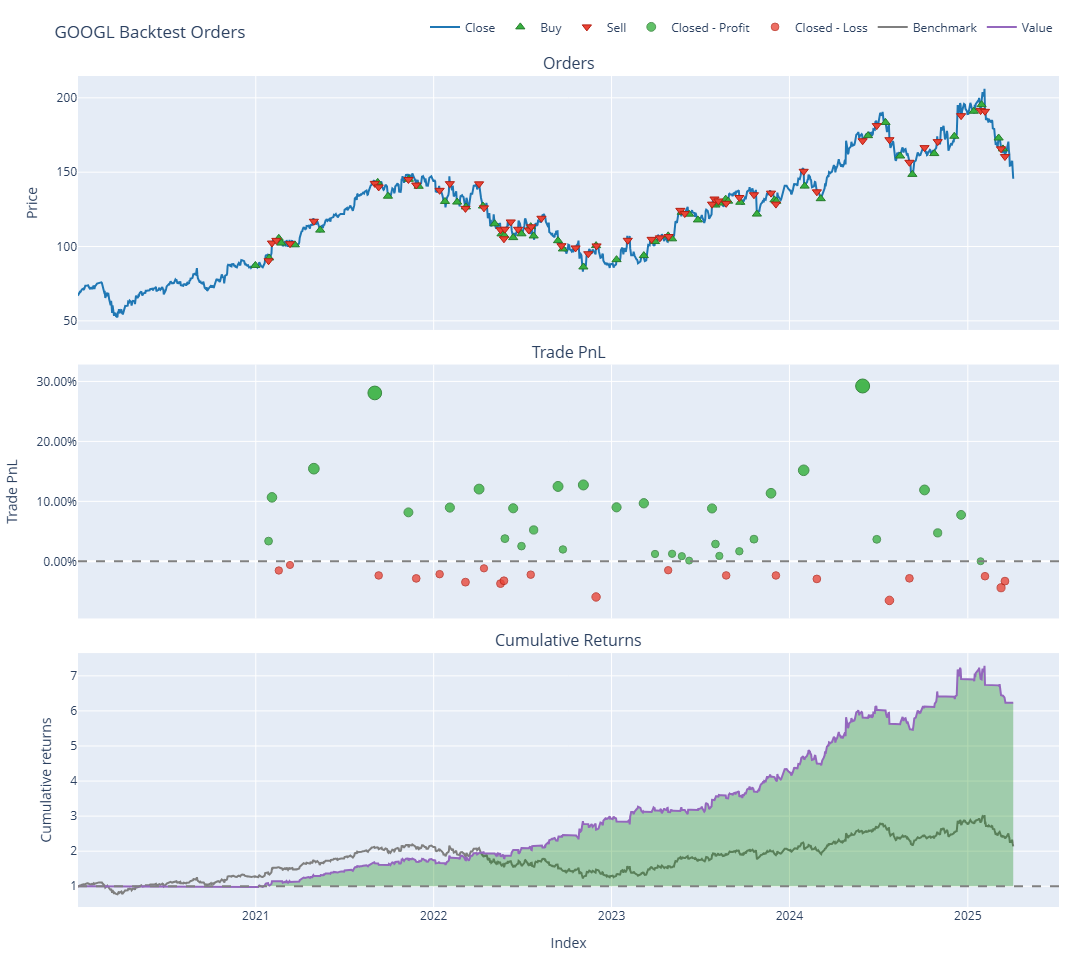

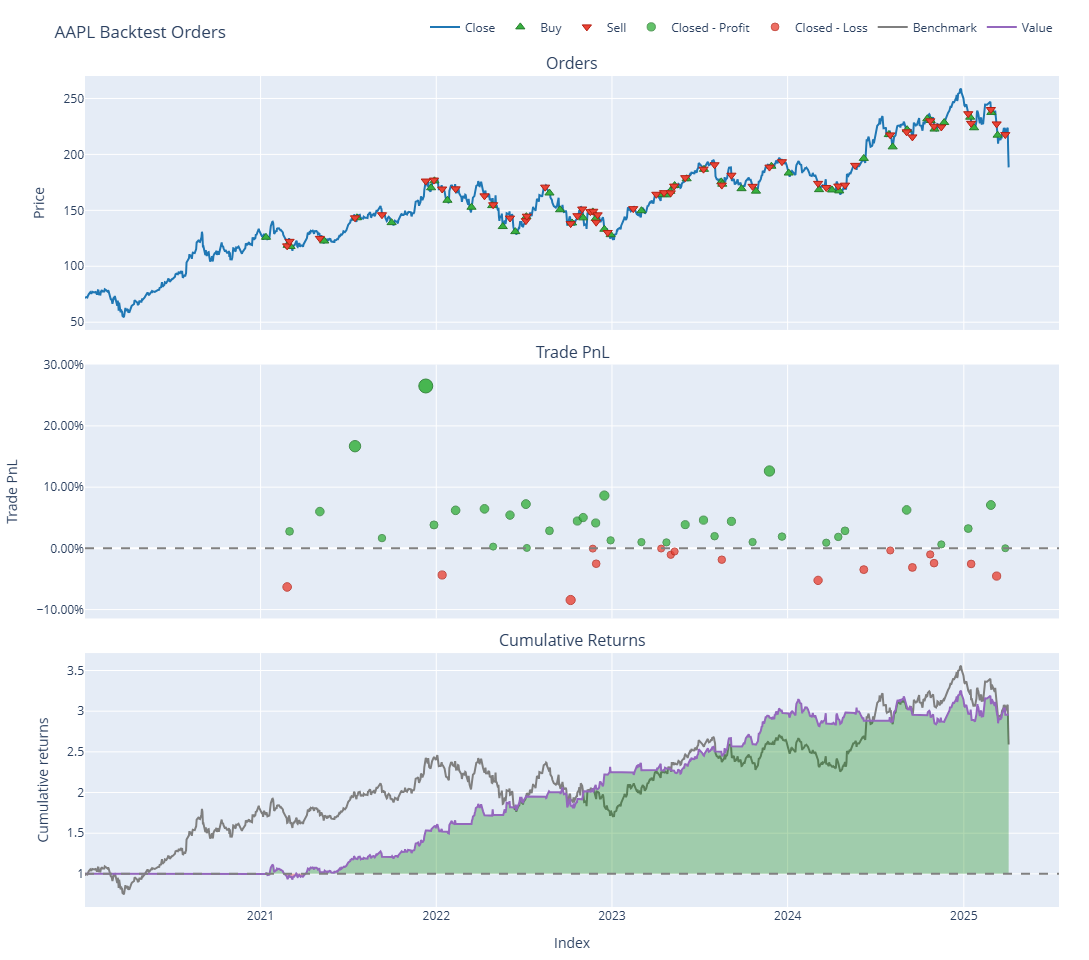

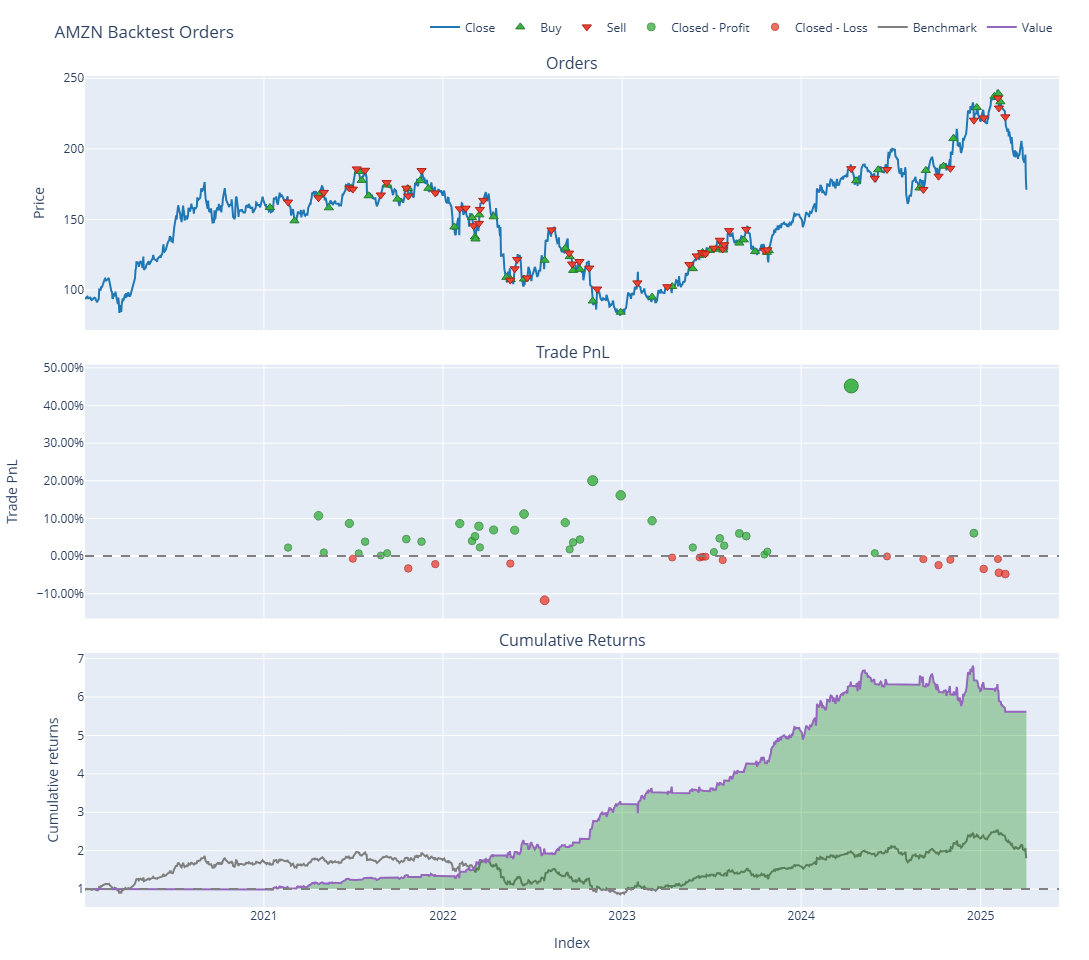

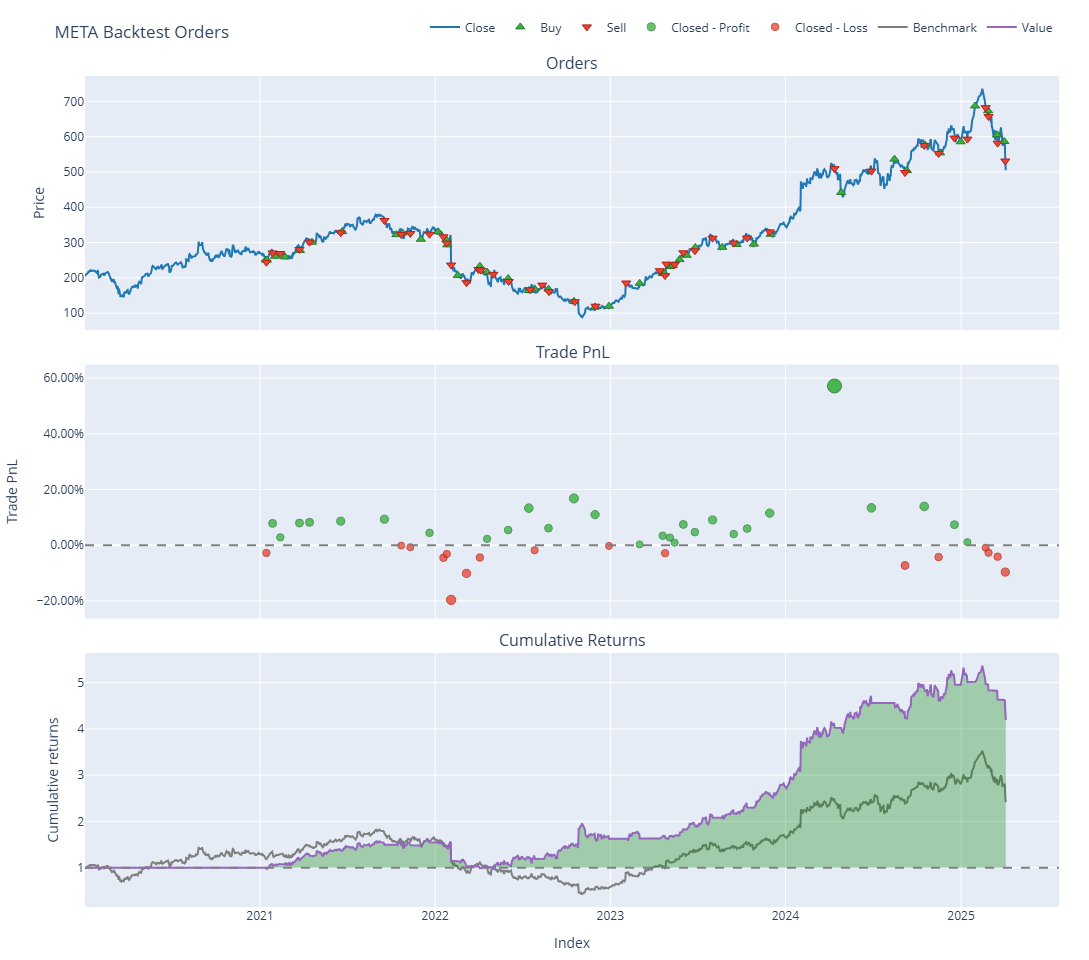

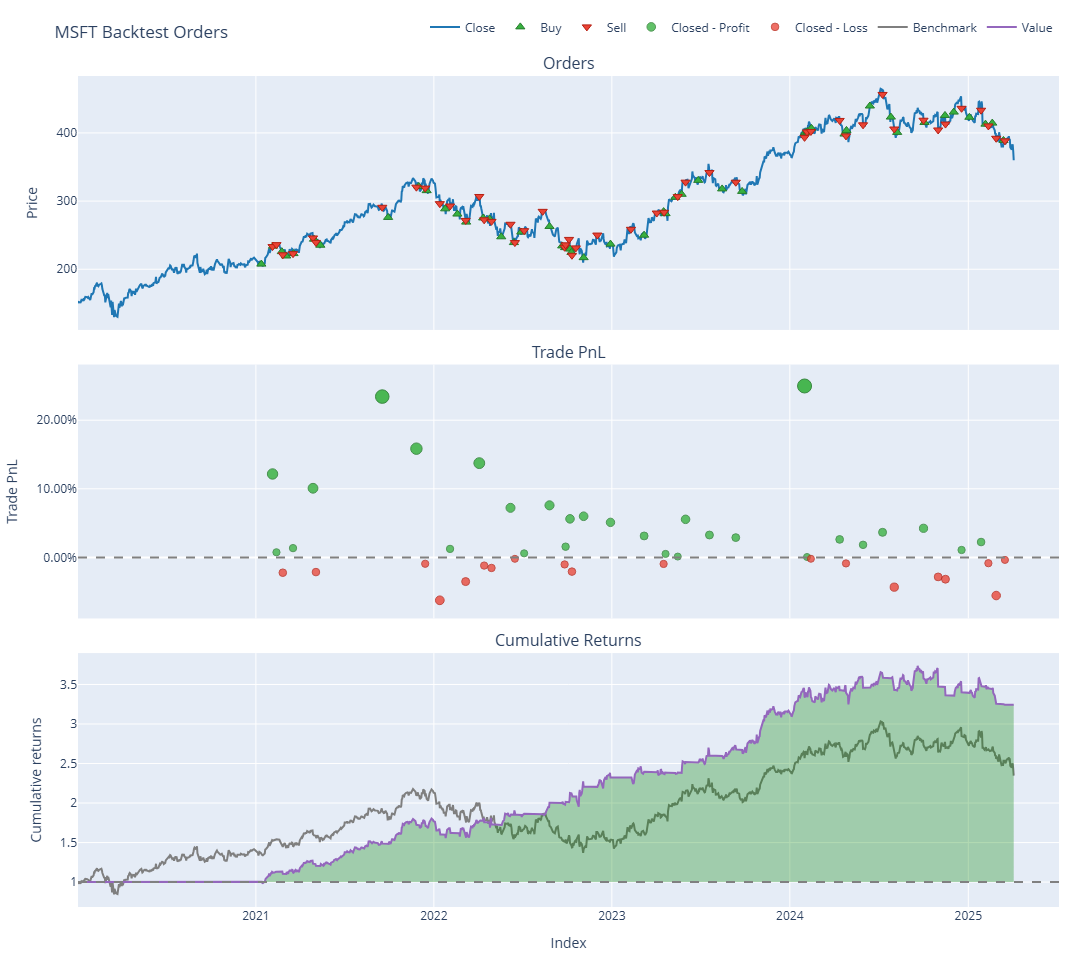

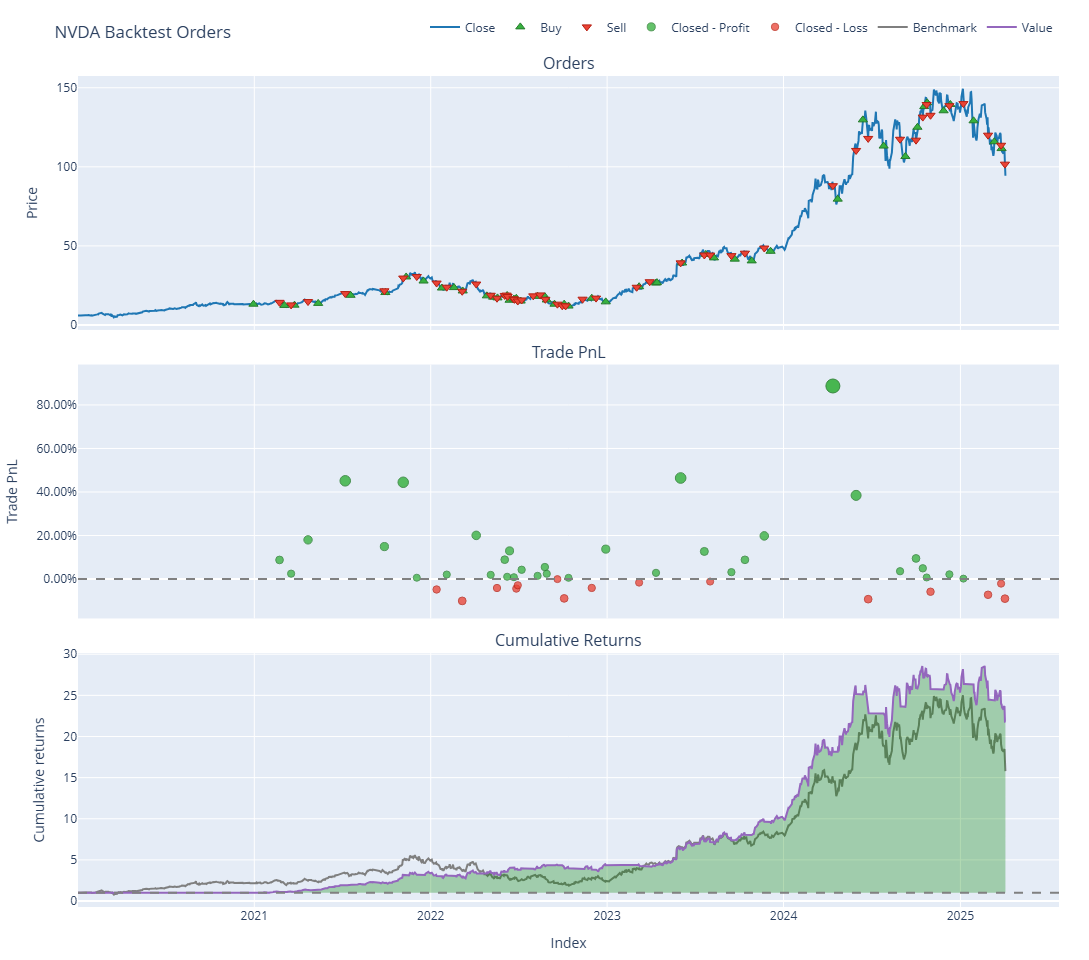

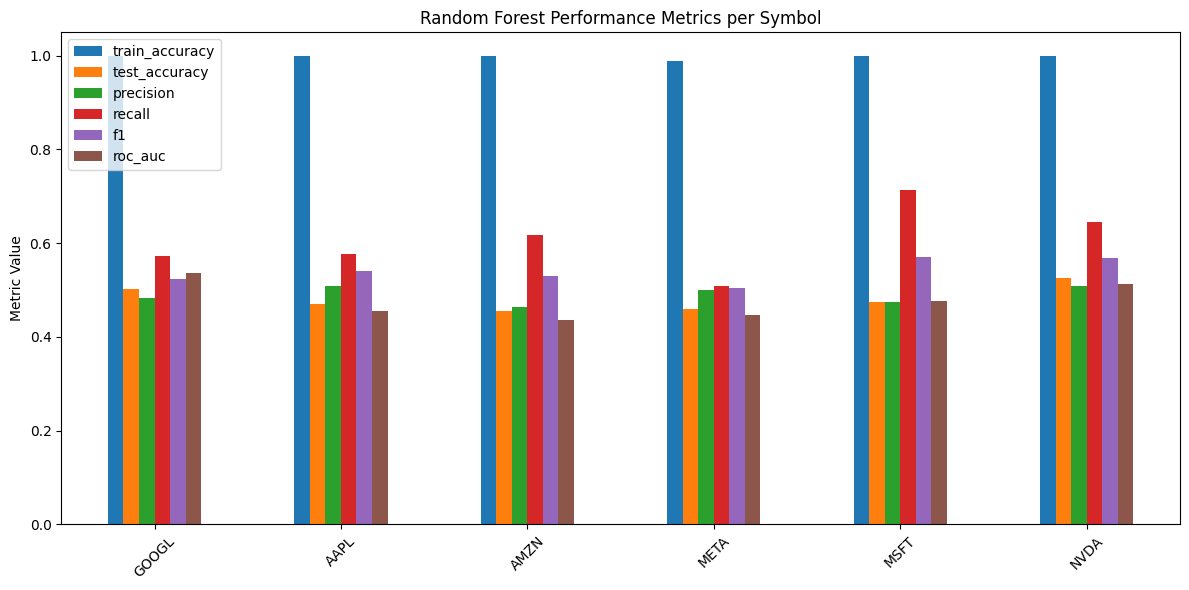

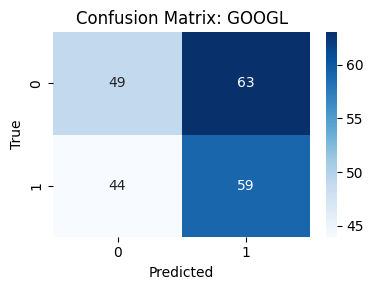

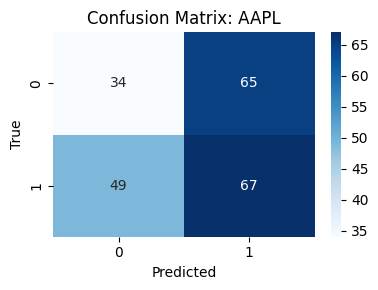

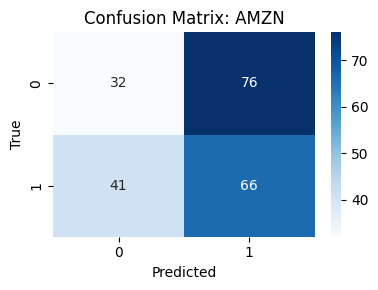

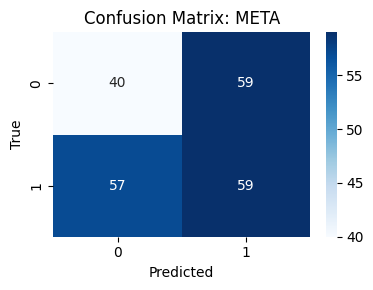

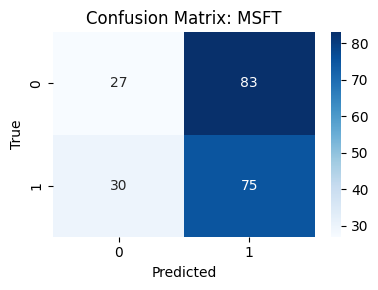

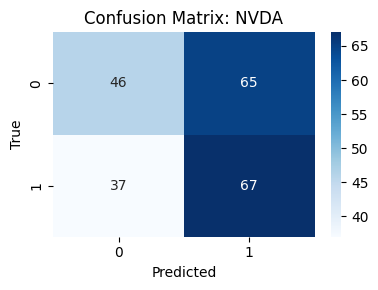

In [7]:
import vectorbt as vbt
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score,f1_score, roc_auc_score, confusion_matrix)
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

class MomentumStrategyVectorBT:
    def __init__(self,
                 symbols=None,
                 momentum_threshold=10.0,      # default threshold for normalized momentum
                 stop_loss_multiplier=2.0,     # adaptive stop loss factor
                 long_prob_threshold=0.6,      # probability threshold for long entries
                 short_prob_threshold=0.4,     # probability threshold for short entries
                 start_date='2020-01-01',
                 end_date=None,
                 rf_params=None):
        if symbols is None:
            symbols = ["GOOGL", "AAPL", "AMZN", "META", "MSFT", "NVDA"]
        self.symbols = symbols
        self.momentum_threshold = momentum_threshold
        self.stop_loss_multiplier = stop_loss_multiplier
        self.long_prob_threshold = long_prob_threshold
        self.short_prob_threshold = short_prob_threshold
        self.start_date = start_date
        self.end_date = end_date if end_date else datetime.now().strftime('%Y-%m-%d')

        if rf_params is None:
            rf_params = {'n_estimators': 100, 'max_depth': None}
        self.rf_params = rf_params

        # Download daily Close prices
        self.price_data = vbt.YFData.download(
            symbols=self.symbols,
            start=self.start_date,
            end=self.end_date
        ).get('Close')

        self.pf = None
        # Dictionary to store various RF performance metrics per symbol
        self.model_performance = {}

    def calculate_momentum(self, df=None):
        """
        Compute the rolling momentum factor using a 252-day window.
        factor = [((close[-21] - close[-252]) / close[-252])
                  - ((close[-1] - close[-21]) / close[-21])]
                 / std(returns over last 126 days)
        """
        if df is None:
            df = self.price_data

        def momentum_factor(window):
            returns = window.pct_change().iloc[-126:]
            std_returns = np.std(returns)
            if std_returns == 0 or np.isnan(std_returns):
                return np.nan
            return (
                ((window.iloc[-21] - window.iloc[-252]) / window.iloc[-252])
                - ((window.iloc[-1] - window.iloc[-21]) / window.iloc[-21])
            ) / std_returns

        return df.rolling(window=252).apply(momentum_factor, raw=False)

    def run_backtest(self):
        # Calculate normalized momentum factor
        momentum = self.calculate_momentum()

        # For each symbol, train RandomForest to predict 5-day forward returns
        prob_df = pd.DataFrame(index=momentum.index, columns=momentum.columns)
        for symbol in self.symbols:
            price = self.price_data[symbol]
            m = momentum[symbol]

            # Calculate 10-day rolling volatility
            vol = price.pct_change().rolling(10).std()
            # RSI via VectorBT
            rsi = vbt.RSI.run(price).rsi

            features = pd.DataFrame({
                'momentum': m,
                'volatility': vol,
                'rsi': rsi
            }).dropna()

            if len(features) < 50:
                continue

            future_return = price.shift(-5) / price - 1
            labels = future_return.loc[features.index]
            labels = (labels > 0).astype(int)

            X = features
            y = labels

            # Split data in a time-series–aware manner
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, shuffle=False, test_size=0.2
            )
            model = RandomForestClassifier(**self.rf_params, random_state=42)
            model.fit(X_train, y_train)

            # Calculate additional metrics on training and test sets
            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)

            train_acc = accuracy_score(y_train, y_train_pred)
            test_acc = accuracy_score(y_test, y_test_pred)
            precision = precision_score(y_test, y_test_pred, zero_division=0)
            recall = recall_score(y_test, y_test_pred, zero_division=0)
            f1 = f1_score(y_test, y_test_pred, zero_division=0)
            roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
            cm = confusion_matrix(y_test, y_test_pred)

            self.model_performance[symbol] = {
                "train_accuracy": train_acc,
                "test_accuracy": test_acc,
                "precision": precision,
                "recall": recall,
                "f1": f1,
                "roc_auc": roc_auc,
                "confusion_matrix": cm
            }
            print(f"{symbol} - Train Accuracy: {train_acc:.2f}, Test Accuracy: {test_acc:.2f}, "
                  f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}, ROC AUC: {roc_auc:.2f}")

            prob = pd.Series(model.predict_proba(X)[:, 1], index=X.index)
            prob = prob.reindex(momentum.index)
            prob_df[symbol] = prob

        # Signals: use momentum threshold and probability thresholds
        base_long_entries = momentum > self.momentum_threshold
        base_short_entries = momentum < -self.momentum_threshold
        corrected_long_entries = base_long_entries & (prob_df > self.long_prob_threshold)
        corrected_short_entries = base_short_entries & (prob_df < self.short_prob_threshold)

        # Adaptive Stop Loss
        daily_returns = self.price_data.pct_change()
        vol_daily = daily_returns.rolling(20).std()
        adaptive_stop_long = daily_returns < (-self.stop_loss_multiplier * vol_daily)
        adaptive_stop_short = daily_returns > (self.stop_loss_multiplier * vol_daily)

        long_exits = (momentum <= self.momentum_threshold) | adaptive_stop_long
        short_exits = (momentum >= -self.momentum_threshold) | adaptive_stop_short

        # Build the portfolio
        self.pf = vbt.Portfolio.from_signals(
            close=self.price_data,
            entries=corrected_long_entries,
            exits=long_exits,
            short_entries=corrected_short_entries,
            short_exits=short_exits,
            fees=0.001,
            slippage=0.001,
            freq='1D'
        )

    def plot_results(self, show_all_symbols=False):
        if self.pf is None:
            print("No portfolio to plot. Please run_backtest() first.")
            return
        if show_all_symbols:
            for symbol in self.price_data.columns:
                fig = self.pf.plot(column=symbol)
                fig.update_layout(title=f"{symbol} Backtest Orders")
                fig.show()
        else:
            first_sym = self.price_data.columns[0]
            fig = self.pf.plot(column=first_sym)
            fig.update_layout(title=f"{first_sym} Backtest Orders")
            fig.show()

    def plot_rf_performance(self):
        """
        Plot a bar chart comparing key Random Forest metrics for each symbol.
        Metrics include training accuracy, test accuracy, precision, recall, f1 score, and ROC AUC.
        """
        if not self.model_performance:
            print("No model performance data available. Run backtest first.")
            return

        metrics = ['train_accuracy', 'test_accuracy', 'precision', 'recall', 'f1', 'roc_auc']
        df_metrics = pd.DataFrame.from_dict(self.model_performance, orient='index')[metrics]

        ax = df_metrics.plot(kind='bar', figsize=(12, 6))
        ax.set_title("Random Forest Performance Metrics per Symbol")
        ax.set_ylabel("Metric Value")
        plt.xticks(rotation=45)
        plt.legend(loc="upper left")
        plt.tight_layout()
        plt.show()

    def plot_confusion_matrices(self):
        """
        Plot confusion matrices for each symbol using a heatmap.
        """
        if not self.model_performance:
            print("No model performance data available. Run backtest first.")
            return

        for symbol, perf in self.model_performance.items():
            cm = perf.get("confusion_matrix")
            if cm is not None:
                plt.figure(figsize=(4, 3))
                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
                plt.title(f"Confusion Matrix: {symbol}")
                plt.xlabel("Predicted")
                plt.ylabel("True")
                plt.tight_layout()
                plt.show()


if __name__ == "__main__":
    # 1. Define your "optimal" parameters
    best_params = {
        "momentum_threshold": 2.0,
        "stop_loss_multiplier": 1.1,
        "n_estimators": 150,
        "max_depth": 15,
        "long_prob_threshold": 0.7,
        "short_prob_threshold": 0.25
    }

    # 2. Build the strategy with those parameters
    best_strategy = MomentumStrategyVectorBT(
        symbols=["GOOGL", "AAPL", "AMZN", "META", "MSFT", "NVDA"],
        start_date="2020-01-01",
        momentum_threshold=best_params["momentum_threshold"],
        stop_loss_multiplier=best_params["stop_loss_multiplier"],
        rf_params={
            "n_estimators": best_params["n_estimators"],
            "max_depth": best_params["max_depth"]
        }
    )
    best_strategy.long_prob_threshold = best_params["long_prob_threshold"]
    best_strategy.short_prob_threshold = best_params["short_prob_threshold"]

    # 3. Run backtest and display portfolio stats
    best_strategy.run_backtest()
    stats = best_strategy.pf.stats(silence_warnings=True)
    print(stats)

    # 4. Plot portfolio results
    best_strategy.plot_results(show_all_symbols=True)

    # 5. Plot Random Forest performance metrics (bar chart)
    best_strategy.plot_rf_performance()

    # 6. Plot confusion matrices for each symbol
    best_strategy.plot_confusion_matrices()